Linear regression model is built in this project to predict fare amount using trip features like distance, duration, passenger count, vendors, hours, etc.

(*Note: data exploration was completed in a previous notebook **EDA - Yellow Taxi Trip 2017***)

In [1]:
import pandas as pd
import numpy as np

from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [2]:
# set theme for plotting
sns.set_theme(style = "darkgrid")

In [3]:
import warnings

# suppress the specific FutureWarning about 'use_inf_as_na'
warnings.filterwarnings('ignore', message = '.*use_inf_as_na.*', category = FutureWarning)
warnings.filterwarnings('ignore', message = '.*get_group.*', category = FutureWarning)

In [4]:
taxi_df = pd.read_csv('/kaggle/input/yellow-taxi-trip-data-2017/C2_2017_Yellow_Taxi_Trip_Data.csv')

## Exploring data with EDA

In [5]:
print('Shape of data:', taxi_df.shape)
print('Shape of data without duplicates:', taxi_df.drop_duplicates().shape)

print('Missing values per column:')
taxi_df.isna().sum()

Shape of data: (22699, 18)
Shape of data without duplicates: (22699, 18)
Missing values per column:


Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [6]:
taxi_df.dtypes

Unnamed: 0                 int64
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [7]:
taxi_df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,22699.0,NaN,NaN,NaN,56758486.171285,32744929.492148,12127.0,28520556.0,56731504.0,85374524.0,113486300.0
VendorID,22699.0,NaN,NaN,NaN,1.556236,0.496838,1.0,1.0,2.0,2.0,2.0
tpep_pickup_datetime,22699,22687,07/03/2017 3:45:19 PM,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpep_dropoff_datetime,22699,22688,10/18/2017 8:07:45 PM,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,22699.0,NaN,NaN,NaN,1.642319,1.285231,0.0,1.0,1.0,2.0,6.0
trip_distance,22699.0,NaN,NaN,NaN,2.913313,3.653171,0.0,0.99,1.61,3.06,33.96
RatecodeID,22699.0,NaN,NaN,NaN,1.043394,0.708391,1.0,1.0,1.0,1.0,99.0
store_and_fwd_flag,22699,2,N,22600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PULocationID,22699.0,NaN,NaN,NaN,162.412353,66.633373,1.0,114.0,162.0,233.0,265.0
DOLocationID,22699.0,NaN,NaN,NaN,161.527997,70.139691,1.0,112.0,162.0,233.0,265.0


- No missing or duplicates
- Outliers observed in:
    -  lower end of `fare_amount`, `total_amount`, etc. with negative values
    -  upper end of `tip_amount`, `fare_amount`, `total_amount`, etc. with extremely high values 

## Feature Engineering

In [8]:
df = taxi_df.copy()

In [9]:
# convert datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [10]:
# create trip duration column
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) / np.timedelta64(1, 'm')

In [11]:
# create & define rush hour as any weekdays AND either from 06:00–10:00 or from 16:00–20:00

df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour

# function to define rush hours
def rush_hour(hour):
    if 6 <= hour['rush_hour'] < 10:
        value = 1
    elif 16 <= hour['rush_hour'] < 20:
        value = 1
    else:
        value = 0
    return value

# exclude weekends
df['day'] = df['tpep_pickup_datetime'].dt.day_name()
df.loc[df['day'].isin(['Saturday', 'Sunday']), 'rush_hour'] = 0

# define rush hour
df['rush_hour'] = df.apply(rush_hour, axis = 1)

In [12]:
df.head(15)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,rush_hour,day
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,13.0,0.0,0.5,2.76,0.00,0.3,16.56,14.066667,0,Saturday
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,16.0,0.0,0.5,4.00,0.00,0.3,20.80,26.500000,0,Tuesday
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.200000,1,Friday
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,0,Sunday
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,16.5,0.5,0.5,0.00,0.00,0.3,17.80,16.716667,0,Saturday
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,...,9.0,0.5,0.5,2.06,0.00,0.3,12.36,8.000000,0,Saturday
6,37660487,2,2017-05-03 19:04:09,2017-05-03 20:03:47,1,12.83,1,N,79,241,...,47.5,1.0,0.5,9.86,0.00,0.3,59.16,59.633333,1,Wednesday
7,69059411,2,2017-08-15 17:41:06,2017-08-15 18:03:05,1,2.98,1,N,237,114,...,16.0,1.0,0.5,1.78,0.00,0.3,19.58,21.983333,1,Tuesday
8,8433159,2,2017-02-04 16:17:07,2017-02-04 16:29:14,1,1.20,1,N,234,249,...,9.0,0.0,0.5,0.00,0.00,0.3,9.80,12.116667,0,Saturday
9,95294817,1,2017-11-10 15:20:29,2017-11-10 15:40:55,1,1.60,1,N,239,237,...,13.0,0.0,0.5,2.75,0.00,0.3,16.55,20.433333,0,Friday


## Handling outliers of the relevant features

In [13]:
df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_duration', 'rush_hour', 'day'],
      dtype='object')

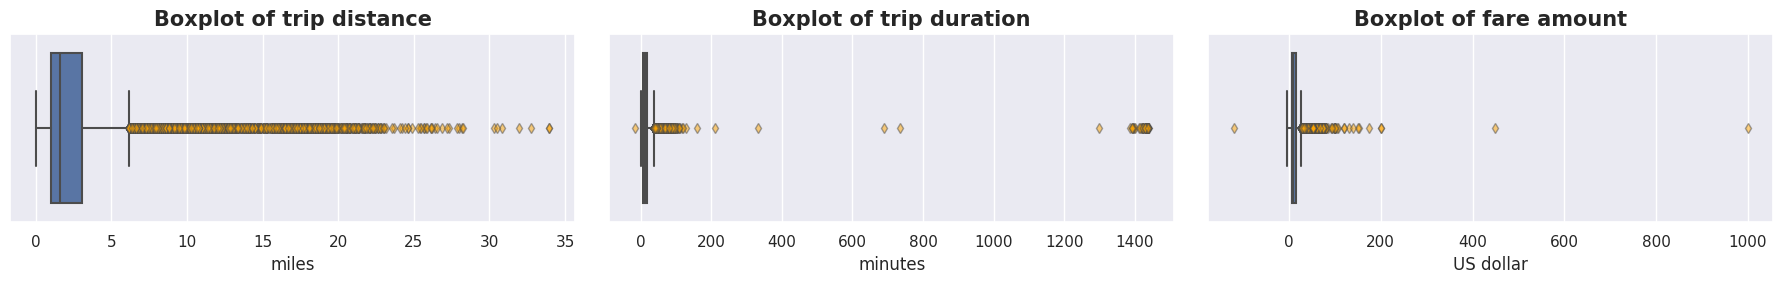

In [14]:
fig = plt.figure(figsize = (18, 3))
ax1 = plt.subplot2grid((1, 3),(0, 0))
ax2 = plt.subplot2grid((1, 3),(0, 1))
ax3 = plt.subplot2grid((1, 3),(0, 2))

# trip distance
sns.boxplot(data = df, x = 'trip_distance', flierprops = dict(markerfacecolor = 'orange', linewidth = 0, alpha = 0.5), ax = ax1)
ax1.set_title('Boxplot of trip distance', fontsize = 15, fontweight = 'bold')
ax1.set_xlabel('miles')

# duration
sns.boxplot(data = df, x = 'trip_duration', flierprops = dict(markerfacecolor = 'orange', linewidth = 0, alpha = 0.5), ax = ax2)
ax2.set_title('Boxplot of trip duration', fontsize = 15, fontweight = 'bold')
ax2.set_xlabel('minutes')

# fare amount
sns.boxplot(data = df, x = 'fare_amount', flierprops = dict(markerfacecolor = 'orange', linewidth = 0, alpha = 0.5), ax = ax3)
ax3.set_title('Boxplot of fare amount', fontsize = 15, fontweight = 'bold')
ax3.set_xlabel('US dollar')


fig.tight_layout()
plt.show();

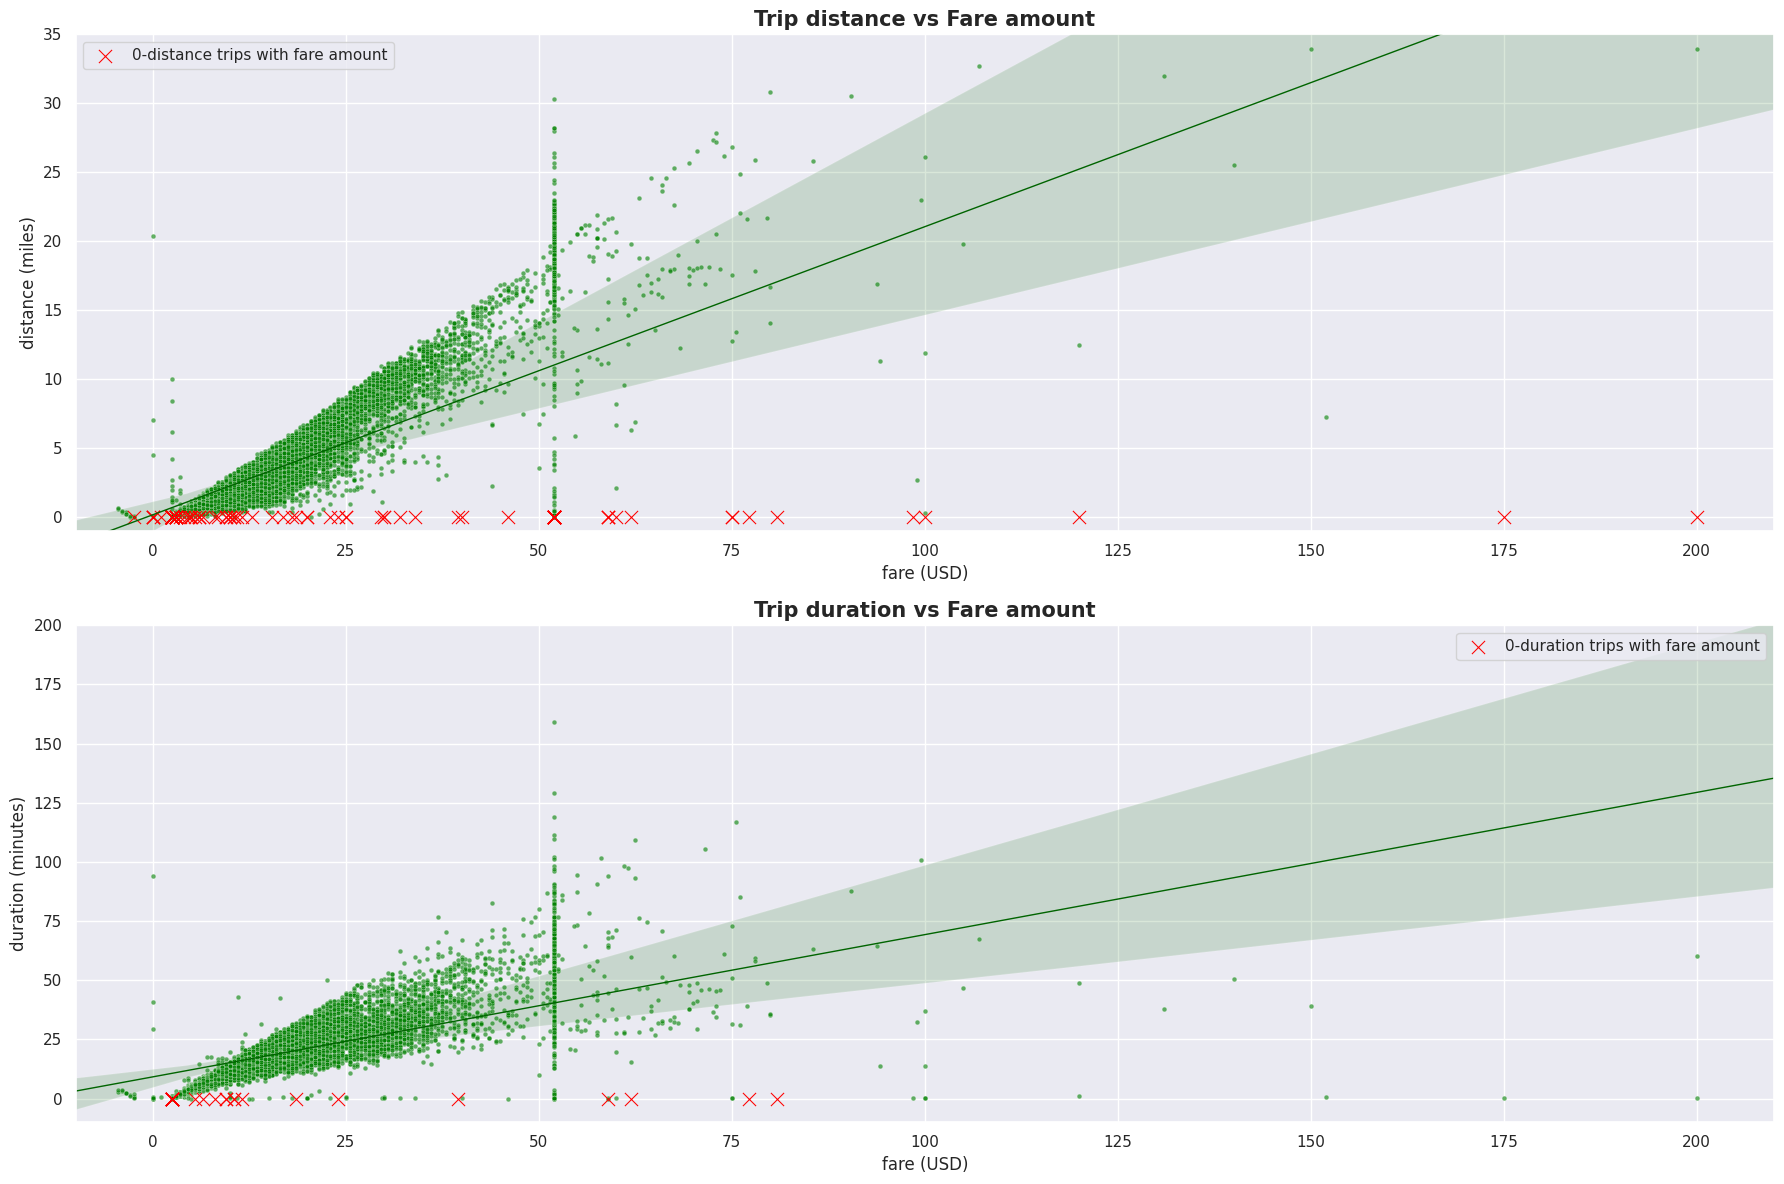

In [15]:
fig = plt.figure(figsize = (18, 12))
ax1 = plt.subplot2grid((2, 1),(0, 0))
ax2 = plt.subplot2grid((2, 1),(1, 0))

x = df['fare_amount']
y1 = df['trip_distance']
y2 = df['trip_duration']
zero_distance = y1 <= 0
zero_duration = y2 <= 0

# trip distance vs fare
sns.regplot(x = x, y = y1, scatter = False, color = 'darkgreen', line_kws = {'linewidth': 1}, ax = ax1)
sns.scatterplot(x = x[~zero_distance], y = y1[~zero_distance], color = 'green', s = 12, alpha = 0.6, ax = ax1)
sns.scatterplot(x = x[zero_distance], y = y1[zero_distance], color = 'red', marker = 'x', s = 90, label = '0-distance trips with fare amount', ax = ax1)
ax1.set_xlim(-10, 210)
ax1.set_xlabel('fare (USD)')
ax1.set_ylim(-1, 35)
ax1.set_ylabel('distance (miles)')
ax1.set_title('Trip distance vs Fare amount', fontsize = 15, fontweight = 'bold')

# trip duration vs fare
sns.regplot(x = x, y = y2, scatter = False, color = 'darkgreen', line_kws = {'linewidth': 1}, ax = ax2)
sns.scatterplot(x = x[~zero_duration], y = y2[~zero_duration], color = 'green', s = 12, alpha = 0.6, ax = ax2)
sns.scatterplot(x = x[zero_duration], y = y2[zero_duration], color = 'red', marker = 'x', s = 90, label = '0-duration trips with fare amount', ax = ax2)
ax2.set_xlim(-10, 210)
ax2.set_xlabel('fare (USD)')
ax2.set_ylim(-10, 200)
ax2.set_ylabel('duration (minutes)')
ax2.set_title('Trip duration vs Fare amount', fontsize = 15, fontweight = 'bold')


fig.tight_layout()
plt.show();

- Possible outliers:
    - Trip with zero distance/mile
    - Both negative and extremely high values in trip duration and fare amount

### `trip_distance` outliers

In [16]:
df[(df['trip_distance'] == 0) & ((df['trip_duration'] > 0) | (df['fare_amount'] > 0))].sort_values(by = 'trip_duration')

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,rush_hour,day
17567,34210304,1,2017-04-25 13:16:31,2017-04-25 13:16:31,1,0.0,1,N,132,264,...,62.00,0.0,0.5,0.00,0.0,0.3,62.80,0.000000,0,Tuesday
17311,19238418,1,2017-03-07 18:16:47,2017-03-07 18:16:47,1,0.0,1,N,162,264,...,2.50,1.0,0.5,0.00,0.0,0.3,4.30,0.000000,1,Tuesday
4742,18394854,1,2017-03-05 06:41:16,2017-03-05 06:41:16,1,0.0,5,N,233,264,...,80.84,0.0,0.0,0.00,0.0,0.3,81.14,0.000000,0,Sunday
17270,20458610,1,2017-03-26 22:48:51,2017-03-26 22:48:51,1,0.0,1,N,170,264,...,2.50,0.5,0.5,0.00,0.0,0.3,3.80,0.000000,0,Sunday
16586,87350785,1,2017-10-17 04:39:44,2017-10-17 04:39:44,1,0.0,1,N,145,264,...,2.50,0.5,0.5,0.00,0.0,0.3,3.80,0.000000,0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,53536625,2,2017-06-23 14:43:42,2017-06-23 14:51:15,6,0.0,1,N,13,13,...,6.00,0.0,0.5,0.00,0.0,0.3,6.80,7.550000,0,Friday
22043,57581462,1,2017-07-06 10:27:11,2017-07-06 10:40:07,1,0.0,2,N,162,162,...,52.00,0.0,0.5,0.00,0.0,0.3,52.80,12.933333,0,Thursday
15916,47368116,1,2017-06-29 19:30:30,2017-06-29 19:43:29,1,0.0,1,N,79,148,...,8.50,1.0,0.5,0.00,0.0,0.3,10.30,12.983333,1,Thursday
20080,55620713,2,2017-06-07 10:27:54,2017-06-07 10:54:23,1,0.0,1,N,107,237,...,15.50,0.0,0.5,0.00,0.0,0.3,16.30,26.483333,0,Wednesday


In [17]:
print('Percentage of trips with zero distance in the data: {:.2f}%'.format(148 / len(df) * 100))

Percentage of trips with zero distance in the data: 0.65%


Trips with 0-mile are likely logging or GPS error; associated with non-zero fare amount or duration, and its proportion is insignificant (out of ~27,000 total trips). These trips won't be taken as outliers and will remain untouched.

### `trip_duration` & `fare_amount` outliers

In [18]:
df['trip_duration'].describe()

count    22699.000000
mean        17.013777
std         61.996482
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: trip_duration, dtype: float64

In [19]:
df['fare_amount'].describe()

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

In [20]:
# invalid trips with negatives
print('Number of invalid trips with less than zero duration:', sum(df['trip_duration'] < 0))
print('Number of invalid trips with negative fare amount:', sum(df['fare_amount'] < 0))

Number of invalid trips with less than zero duration: 1
Number of invalid trips with negative fare amount: 14


In [21]:
print('99% of trip duration are less than or equal to {:.0f} minutes.'.format(df['trip_duration'].quantile(0.99)))
print('99% of fare amounts are less than or equal to ${}.'.format(df['fare_amount'].quantile(0.99)))

99% of trip duration are less than or equal to 60 minutes.
99% of fare amounts are less than or equal to $52.0.


In [22]:
# function to impute outliers
def impute_outliers(df, col, iqr_factor):
    '''
    impute lower limit values with 0.
    impute upper limit values based on IQR of the column using the formula Q3 + (iqr_factor * IQR).
    '''
    lower_limit = 0

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + (iqr_factor * iqr)

    print(col)
    print('Q3', q3)
    print('Upper limit', upper_limit)

    df[col] = df[col].clip(lower = lower_limit, upper = upper_limit)
    print(df[col].describe())

In [23]:
# impute outliers in trip duration and fare amount using iqr_factor = 6
for col in ['trip_duration', 'fare_amount']:
    impute_outliers(df, col, 6)

trip_duration
Q3 18.383333333333333
Upper limit 88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: trip_duration, dtype: float64
fare_amount
Q3 14.5
Upper limit 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64


## Feature Engineering II

Some of the predictor variables used to train the model were unknown until after the trip, namely `trip_distance` and `trip_duration`.

From both pick-up and drop-off zones, two new columns created to represent the average trip distance and average trip duration; which will be used in model training.

In [24]:
# calculate averages
avg_df = (
    df.groupby(['PULocationID', 'DOLocationID'])[['trip_distance', 'trip_duration']]
    .mean()
    .reset_index()
    .rename(columns = {
        'trip_distance': 'mean_distance',
        'trip_duration': 'mean_duration'
    })
)

avg_df.head()

,PULocationID,DOLocationID,mean_distance,mean_duration
0,1,1,2.433333,0.466667
1,4,4,0.320000,1.825000
2,4,37,5.480000,21.500000
3,4,45,2.240000,9.250000
4,4,74,5.590000,20.433333


In [25]:
df = df.merge(avg_df, on = ['PULocationID', 'DOLocationID'], how = 'left')

# check
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['mean_distance', 'mean_duration']]

,mean_distance,mean_duration
0,3.521667,22.847222
4909,3.521667,22.847222
16636,3.521667,22.847222
18134,3.521667,22.847222
19761,3.521667,22.847222
20581,3.521667,22.847222


The vertical lines in above scatterplots suggest there are quite number of fare with the same amount.

In [26]:
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

fare_amount
52.0    514
62.5     84
59.0      9
50.5      9
57.5      8
Name: count, dtype: int64

In [27]:
df[df['fare_amount'] == 52.0].sort_values(by = 'RatecodeID')

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,rush_hour,day,mean_distance,mean_duration
22686,9039930,2,2017-02-08 18:13:26,2017-02-08 19:34:11,5,10.64,1,N,170,70,...,0.5,14.84,5.54,0.3,74.18,80.750000,1,Wednesday,10.640000,80.750000
14864,111695894,2,2017-01-16 17:31:49,2017-01-16 18:28:18,1,16.67,2,N,229,132,...,0.5,0.00,0.00,0.3,52.80,56.483333,1,Monday,16.683333,46.044444
14816,46630636,2,2017-05-31 16:34:56,2017-05-31 17:27:35,1,18.47,2,N,132,148,...,0.5,11.46,0.00,0.3,68.76,52.650000,1,Wednesday,17.994286,46.340476
14736,76092147,1,2017-09-10 14:48:24,2017-09-10 16:11:11,1,19.80,2,N,132,48,...,0.5,13.00,0.00,0.3,65.80,82.783333,0,Sunday,18.761905,58.246032
14704,109474580,1,2017-12-26 10:21:40,2017-12-26 10:59:48,2,17.90,2,N,132,186,...,0.5,0.00,5.76,0.3,58.56,38.133333,0,Tuesday,18.375000,56.436111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145,108735316,2,2017-12-22 18:42:42,2017-12-22 19:42:18,3,19.29,2,N,43,132,...,0.5,11.46,0.00,0.3,68.76,59.600000,1,Friday,18.657500,41.279167
7131,19983053,1,2017-03-09 18:23:20,2017-03-09 19:21:04,1,20.60,2,N,132,88,...,0.5,0.00,5.54,0.3,62.84,57.733333,1,Thursday,20.600000,57.733333
7129,56045518,2,2017-06-09 21:24:23,2017-06-09 22:10:11,1,18.12,2,N,132,68,...,0.5,7.44,5.76,0.3,66.00,45.800000,0,Friday,18.797500,52.545833
11004,42250139,2,2017-05-11 21:29:00,2017-05-11 22:22:40,3,16.91,2,N,186,132,...,0.5,11.71,5.76,0.3,70.27,53.666667,0,Thursday,17.096000,42.920000


In [28]:
sum(df['RatecodeID'] == 2)

513

According to the data dictionary and online research, `RatecodeID = 2` indicates a trip from JFK airport to Manhattan with flat rate of $52.

These 513 trips will be omitted in model training.

## Selecting Modeling Variables

In [29]:
variables = ['VendorID', 'passenger_count', 'rush_hour', 'mean_distance', 'mean_duration', 'fare_amount']

In [30]:
df2 = df[df['RatecodeID'] != 2][variables]
df2

,VendorID,passenger_count,rush_hour,mean_distance,mean_duration,fare_amount
0,2,6,0,3.521667,22.847222,13.0
1,1,1,0,3.108889,24.470370,16.0
2,1,1,1,0.881429,7.250000,6.5
3,2,1,0,3.700000,30.250000,20.5
4,2,1,0,4.435000,14.616667,16.5
...,...,...,...,...,...,...
22693,2,1,0,1.062778,8.095370,7.5
22694,2,3,1,1.098214,8.594643,4.0
22696,2,1,0,0.684242,6.609091,4.5
22697,2,1,0,2.077500,16.650000,10.5


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


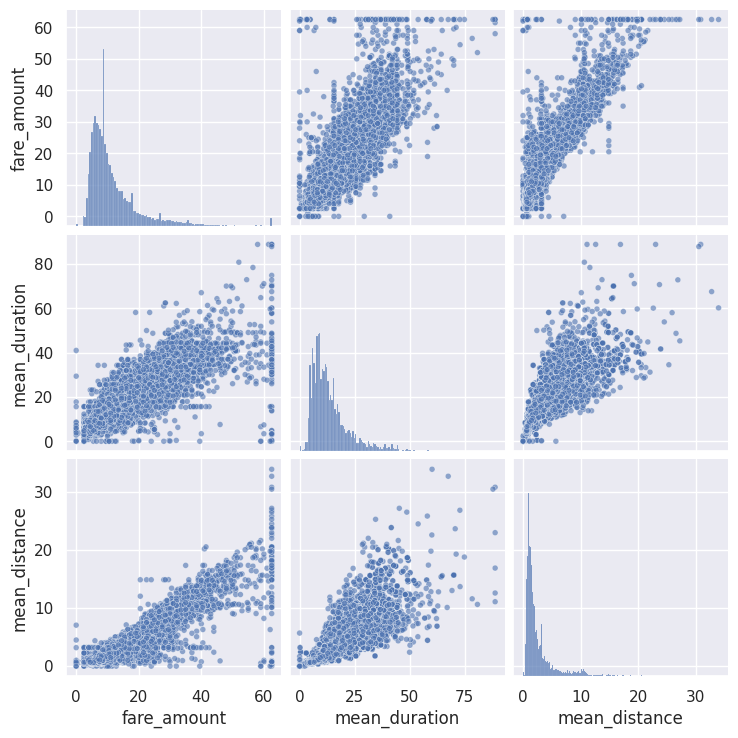

In [31]:
# pair plot
sns.pairplot(df2[['fare_amount', 'mean_duration', 'mean_distance']], plot_kws = {'alpha': 0.6, 'size': 3});

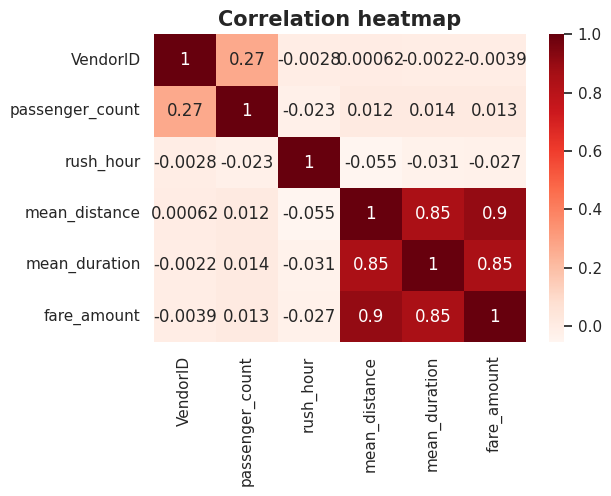

In [32]:
# correlation heatmap
plt.figure(figsize = (6, 4))
sns.heatmap(df2.corr(method = 'pearson'), annot = True, cmap = 'Reds')
plt.title('Correlation heatmap', fontsize = 15, fontweight = 'bold');

## Data pre-processing for modeling

In [33]:
X = df2[variables[:-1]]
y = df2[variables[-1]]

In [34]:
# one-hot encoding
X = pd.get_dummies(X, drop_first = True)
X.head()

,VendorID,passenger_count,rush_hour,mean_distance,mean_duration
0,2,6,0,3.521667,22.847222
1,1,1,0,3.108889,24.470370
2,1,1,1,0.881429,7.250000
3,2,1,0,3.700000,30.250000
4,2,1,0,4.435000,14.616667


In [35]:
# normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.89422765,  3.3915348 , -0.64919222,  0.32981526,  1.03368465],
       [-1.11828347, -0.49868292, -0.64919222,  0.18249636,  1.21843128],
       [-1.11828347, -0.49868292,  1.54037582, -0.61247616, -0.74159028],
       ...,
       [ 0.89422765, -0.49868292, -0.64919222, -0.68285118, -0.81453851],
       [ 0.89422765, -0.49868292, -0.64919222, -0.1856026 ,  0.32831718],
       [-1.11828347, -0.49868292, -0.64919222, -0.39992969, -0.49624507]])

## Model Fitting and Evaluation

In [36]:
# split into training & test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

In [37]:
# fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [38]:
# evaluate with test data
r_sq = lr.score(X_test, y_test)
print('Coefficient of determination:', r_sq)
y_pred = lr.predict(X_test)
print('R^2:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test,y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred)))

Coefficient of determination: 0.8198094944887764
R^2: 0.8198094944887764
MAE: 2.0324848428890894
MSE: 14.59759206089559
RMSE: 3.8206795286827693


- The model explains approximately 82% of the variability in `fare_amount`
- On average, the predictions are about \$2 off from the actual fare
- Most prediction errors fall within ±$3.8

## Visualizing model results

In [39]:
results = pd.DataFrame(
    data = {'actual': y_test.to_numpy(), 
            'predicted': y_pred.ravel()}
)

results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
0,13.0,12.050557,0.949443
1,41.5,13.996795,27.503205
2,5.5,7.258614,-1.758614
3,3.5,4.425441,-0.925441
4,16.0,18.167593,-2.167593


In [40]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_}).sort_values(by = 'Coefficient', ascending = False)
coef_df

,Feature,Coefficient
3,mean_distance,5.754077
4,mean_duration,2.621280
2,rush_hour,0.141755
1,passenger_count,0.006646
0,VendorID,-0.024495


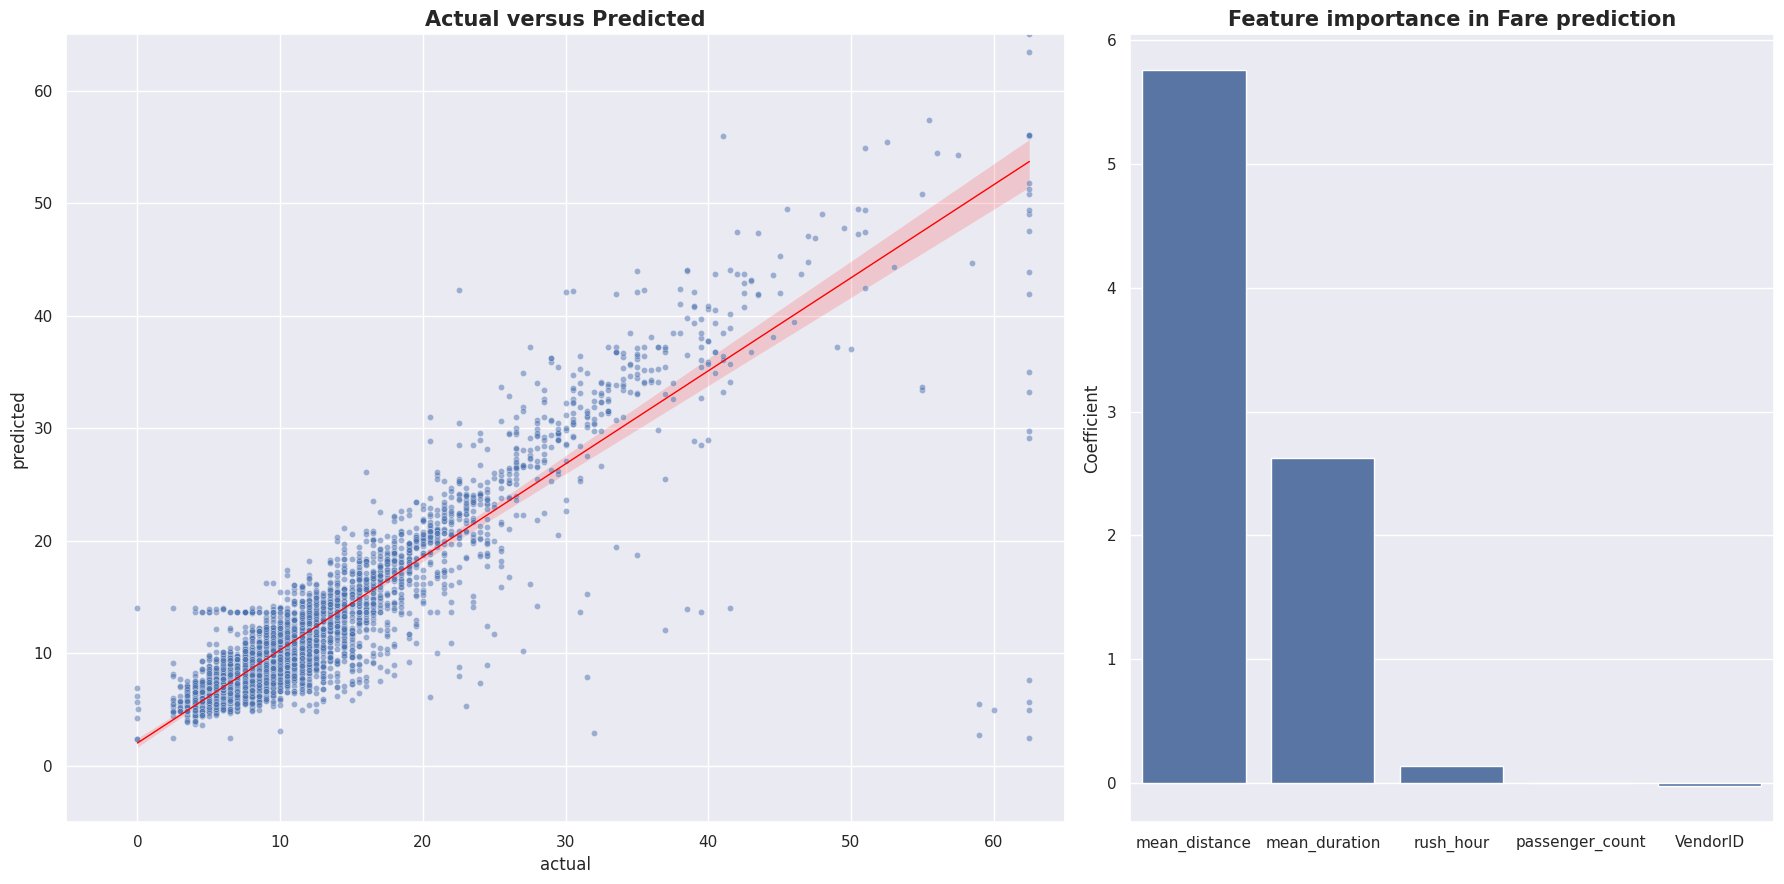

In [41]:
fig = plt.figure(figsize = (18, 9))
ax1 = plt.subplot2grid((1, 5),(0, 0), colspan = 3)
ax2 = plt.subplot2grid((1, 5),(0, 3), colspan = 2)


# actual vs predicted
sns.regplot(data = results, x = 'actual', y = 'predicted', scatter = False, color = 'red', line_kws = {'linewidth': 1}, ax = ax1)
sns.scatterplot(data = results, x = 'actual', y = 'predicted', s = 20, alpha = 0.5, ax = ax1)
ax1.set_title('Actual versus Predicted', fontsize = 15, fontweight = 'bold')
ax1.set_xlim(-5, 65)
ax1.set_ylim(-5, 65)

# feature importance
sns.barplot(data = coef_df, x = 'Feature', y = 'Coefficient', color = 'b', ax = ax2)
ax2.set_title('Feature importance in Fare prediction', fontsize = 15, fontweight = 'bold')
ax2.set_xlabel('')


fig.tight_layout()
plt.savefig('predict_vs_actual.png', dpi = 300, bbox_inches = 'tight')
plt.show();

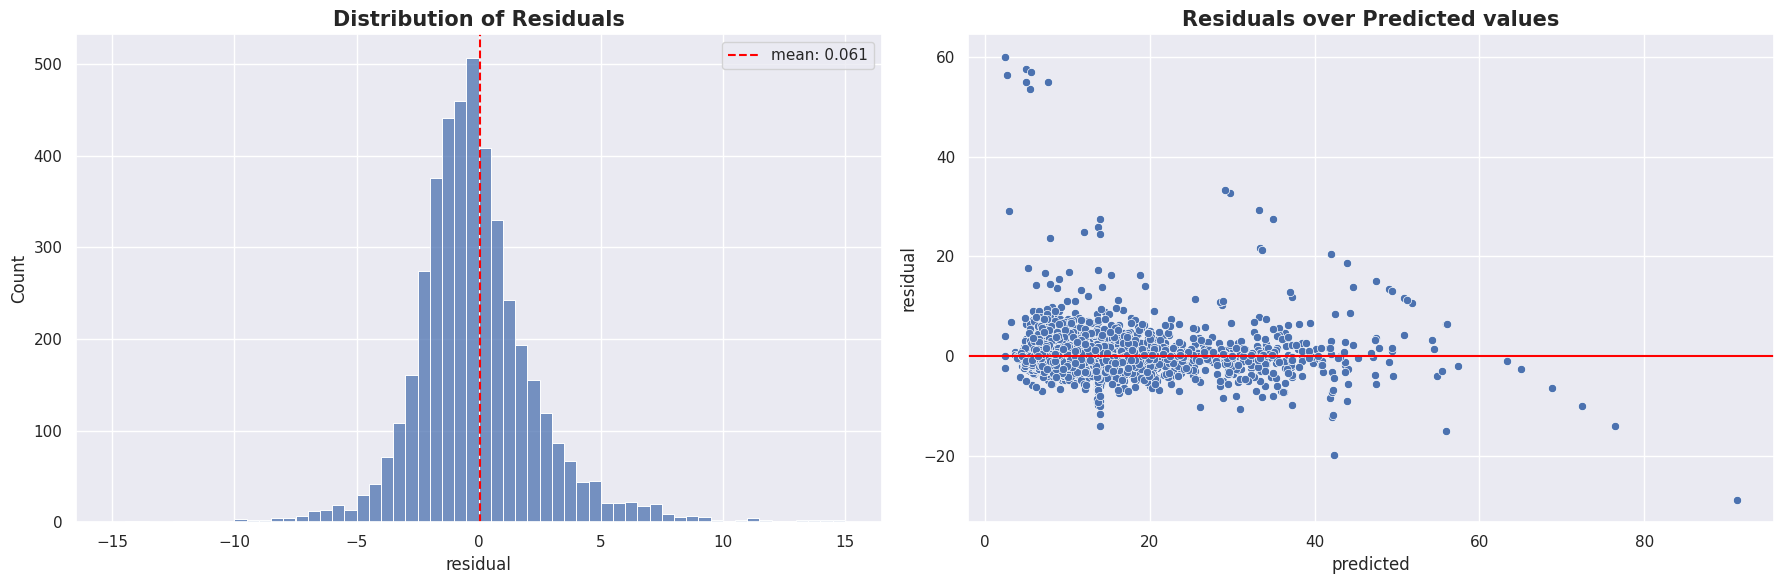

In [42]:
fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot2grid((1, 2),(0, 0))
ax2 = plt.subplot2grid((1, 2),(0, 1))

# residual distribution
sns.histplot(results['residual'], bins = np.arange(-15, 15.5, 0.5), ax = ax1)
ax1.axvline(results['residual'].mean(), ls = '--', c = 'red', label = 'mean: {:.3f}'.format(results['residual'].mean()))
ax1.legend()
ax1.set_title('Distribution of Residuals', fontsize = 15, fontweight = 'bold')
ax1.set_ylabel('Count')

# residual over predicted
sns.scatterplot(data = results, x = 'predicted', y = 'residual', ax = ax2)
ax2.axhline(0, c = 'red')
ax2.set_title('Residuals over Predicted values', fontsize = 15, fontweight = 'bold')


fig.tight_layout()
plt.show();

The distribution of the residuals is normal and has a mean of 0.061.

The residuals are randomly scattered above and below zero across the range of predicted values, with the exception of the sloping lines from the upper-left corner to the lower-right corner which represents the imputed maximum value of \$62.50.

These residual analysis suggest that the model is unbiased and makes consistent predictions.

***Splitting dataset and calculating the averages using only the training data would help to prevent data leakage; doing so leads to NaNs in the test data as these pickup-dropoff locations combinations were not observed in the training data.***

***In this study, data leakage was not being considered, i.e. the averages (trip distance and duration) were calculated using the whole dataset <u>before</u> `train_test_split()`, which could contaminate the test data.***